# Imports

In [10]:
import numpy as np
import random
np.random.seed(42)
random.seed(42)
from hmmlearn import hmm
import seaborn as sns
import matplotlib.pyplot as plt

# MDP Steup (We are not using the MDP but it contains the original markov chain probs - and only they will be used)

In [ ]:
states = [
    "Home Page", "Search Results", "(Product Page, Neutral)", "Reading Reviews",
    "Viewing 'Customers Also Bought'", "(Product Page, Positive)",
    "(Product Page, Negative)", "Added to Wishlist", "Added to Cart",
    "Checking Shipping Details", "At Checkout", "Purchase Complete", "Left Site"
]
s_map = {s: i for i, s in enumerate(states)}
num_states = len(states)

In [ ]:
actions = [
    "Do Nothing", "Show Personalized Banner", "Boost Sponsored Product",
    "Offer 10% Discount", "Show 'Low in Stock!' Alert", "Highlight 5-Star Review",
    "Inject High-Margin Item", "Send Sale Email", "Offer Free Shipping",
    "Offer Expedited Shipping Discount", "Show Trust Badges",
    "Collect Reward", "End Session"
]
a_map = {a: i for i, a in enumerate(actions)}
num_actions = len(actions)

In [ ]:
rewards = np.zeros((num_states, num_actions))

# Default "cost of time" for Do Nothing
rewards[:, a_map["Do Nothing"]] = -1

# Action costs
rewards[s_map["Home Page"], a_map["Show Personalized Banner"]] = -2
rewards[s_map["Search Results"], a_map["Boost Sponsored Product"]] = -2
rewards[s_map["(Product Page, Neutral)"], a_map["Offer 10% Discount"]] = -10
rewards[s_map["(Product Page, Neutral)"], a_map["Show 'Low in Stock!' Alert"]] = -2
rewards[s_map["(Product Page, Positive)"], a_map["Offer 10% Discount"]] = -10
rewards[s_map["(Product Page, Positive)"], a_map["Show 'Low in Stock!' Alert"]] = -2
rewards[s_map["(Product Page, Negative)"], a_map["Offer 10% Discount"]] = -10
rewards[s_map["(Product Page, Negative)"], a_map["Show 'Low in Stock!' Alert"]] = -2
rewards[s_map["Reading Reviews"], a_map["Highlight 5-Star Review"]] = -2
rewards[s_map["Viewing 'Customers Also Bought'"], a_map["Inject High-Margin Item"]] = -2
rewards[s_map["Added to Wishlist"], a_map["Send Sale Email"]] = -15
rewards[s_map["Added to Cart"], a_map["Offer Free Shipping"]] = -15
rewards[s_map["Added to Cart"], a_map["Offer 10% Discount"]] = -10
rewards[s_map["Checking Shipping Details"], a_map["Offer Expedited Shipping Discount"]] = -10
rewards[s_map["At Checkout"], a_map["Show Trust Badges"]] = -2

# Terminal state rewards
rewards[s_map["Purchase Complete"], a_map["Collect Reward"]] = 1000
rewards[s_map["Left Site"], a_map["End Session"]] = -100

In [ ]:
# --- 4. Transition Probabilities P(s' | s, a) ---
transitions = np.zeros((num_actions, num_states, num_states))
a_dn = a_map["Do Nothing"] # Index for "Do Nothing" action

# --- Baseline Probabilities (for 'Do Nothing' actions) ---
transitions[a_dn, s_map["Home Page"], s_map["Search Results"]] = 0.80
transitions[a_dn, s_map["Home Page"], s_map["Left Site"]] = 0.20

transitions[a_dn, s_map["Search Results"], s_map["(Product Page, Neutral)"]] = 0.60
transitions[a_dn, s_map["Search Results"], s_map["Search Results"]] = 0.25
transitions[a_dn, s_map["Search Results"], s_map["Home Page"]] = 0.05
transitions[a_dn, s_map["Search Results"], s_map["Left Site"]] = 0.10

transitions[a_dn, s_map["(Product Page, Neutral)"], s_map["Reading Reviews"]] = 0.40
transitions[a_dn, s_map["(Product Page, Neutral)"], s_map["Added to Cart"]] = 0.15
transitions[a_dn, s_map["(Product Page, Neutral)"], s_map["Viewing 'Customers Also Bought'"]] = 0.15
transitions[a_dn, s_map["(Product Page, Neutral)"], s_map["Search Results"]] = 0.15
transitions[a_dn, s_map["(Product Page, Neutral)"], s_map["Added to Wishlist"]] = 0.10
transitions[a_dn, s_map["(Product Page, Neutral)"], s_map["Left Site"]] = 0.05

transitions[a_dn, s_map["Reading Reviews"], s_map["(Product Page, Positive)"]] = 0.50
transitions[a_dn, s_map["Reading Reviews"], s_map["(Product Page, Neutral)"]] = 0.20
transitions[a_dn, s_map["Reading Reviews"], s_map["(Product Page, Negative)"]] = 0.20
transitions[a_dn, s_map["Reading Reviews"], s_map["Left Site"]] = 0.10

transitions[a_dn, s_map["Viewing 'Customers Also Bought'"], s_map["(Product Page, Neutral)"]] = 0.60
transitions[a_dn, s_map["Viewing 'Customers Also Bought'"], s_map["Search Results"]] = 0.20
transitions[a_dn, s_map["Viewing 'Customers Also Bought'"], s_map["Home Page"]] = 0.10
transitions[a_dn, s_map["Viewing 'Customers Also Bought'"], s_map["Left Site"]] = 0.10

transitions[a_dn, s_map["(Product Page, Positive)"], s_map["Added to Cart"]] = 0.70
transitions[a_dn, s_map["(Product Page, Positive)"], s_map["Search Results"]] = 0.10
transitions[a_dn, s_map["(Product Page, Positive)"], s_map["Added to Wishlist"]] = 0.10
transitions[a_dn, s_map["(Product Page, Positive)"], s_map["Left Site"]] = 0.10

transitions[a_dn, s_map["(Product Page, Negative)"], s_map["Search Results"]] = 0.70
transitions[a_dn, s_map["(Product Page, Negative)"], s_map["Left Site"]] = 0.25
transitions[a_dn, s_map["(Product Page, Negative)"], s_map["Home Page"]] = 0.05

transitions[a_dn, s_map["Added to Wishlist"], s_map["Left Site"]] = 0.60
transitions[a_dn, s_map["Added to Wishlist"], s_map["Search Results"]] = 0.20
transitions[a_dn, s_map["Added to Wishlist"], s_map["Home Page"]] = 0.20

transitions[a_dn, s_map["Added to Cart"], s_map["At Checkout"]] = 0.60
transitions[a_dn, s_map["Added to Cart"], s_map["Search Results"]] = 0.25
transitions[a_dn, s_map["Added to Cart"], s_map["Home Page"]] = 0.05
transitions[a_dn, s_map["Added to Cart"], s_map["Left Site"]] = 0.10

transitions[a_dn, s_map["Checking Shipping Details"], s_map["At Checkout"]] = 0.80
transitions[a_dn, s_map["Checking Shipping Details"], s_map["Left Site"]] = 0.20

transitions[a_dn, s_map["At Checkout"], s_map["Purchase Complete"]] = 0.75
transitions[a_dn, s_map["At Checkout"], s_map["Checking Shipping Details"]] = 0.10
transitions[a_dn, s_map["At Checkout"], s_map["Added to Cart"]] = 0.05
transitions[a_dn, s_map["At Checkout"], s_map["Left Site"]] = 0.10

transitions[a_dn, s_map["Purchase Complete"], s_map["Purchase Complete"]] = 1.0
transitions[a_dn, s_map["Left Site"], s_map["Left Site"]] = 1.0

# --- Action-Modified Probabilities ---
# Home Page
a = a_map["Show Personalized Banner"]
s = s_map["Home Page"]
transitions[a, s, s_map["Search Results"]] = 0.85
transitions[a, s, s_map["Left Site"]] = 0.15

# Search Results
a = a_map["Boost Sponsored Product"]
s = s_map["Search Results"]
transitions[a, s, s_map["(Product Page, Neutral)"]] = 0.70
transitions[a, s, s_map["Search Results"]] = 0.20
transitions[a, s, s_map["Left Site"]] = 0.05
transitions[a, s, s_map["Home Page"]] = 0.05

s = s_map["(Product Page, Neutral)"]
a = a_map["Offer 10% Discount"]
transitions[a, s, s_map["Added to Cart"]] = 0.45
transitions[a, s, s_map["Reading Reviews"]] = 0.20
transitions[a, s, s_map["Viewing 'Customers Also Bought'"]] = 0.15
transitions[a, s, s_map["Added to Wishlist"]] = 0.10
transitions[a, s, s_map["Search Results"]] = 0.05
transitions[a, s, s_map["Left Site"]] = 0.05

a = a_map["Show 'Low in Stock!' Alert"]
transitions[a, s, s_map["Added to Cart"]] = 0.35
transitions[a, s, s_map["Added to Wishlist"]] = 0.15
transitions[a, s, s_map["Reading Reviews"]] = 0.30
transitions[a, s, s_map["Viewing 'Customers Also Bought'"]] = 0.10
transitions[a, s, s_map["Search Results"]] = 0.05
transitions[a, s, s_map["Left Site"]] = 0.05

# Reading Reviews
a = a_map["Highlight 5-Star Review"]
s = s_map["Reading Reviews"]
transitions[a, s, s_map["(Product Page, Positive)"]] = 0.65
transitions[a, s, s_map["(Product Page, Neutral)"]] = 0.15
transitions[a, s, s_map["(Product Page, Negative)"]] = 0.10
transitions[a, s, s_map["Left Site"]] = 0.10

# Viewing 'Customers Also Bought'
a = a_map["Inject High-Margin Item"]
s = s_map["Viewing 'Customers Also Bought'"]
transitions[a, s, s_map["(Product Page, Neutral)"]] = 0.75
transitions[a, s, s_map["Search Results"]] = 0.15
transitions[a, s, s_map["Home Page"]] = 0.05
transitions[a, s, s_map["Left Site"]] = 0.05

# (Product Page, Positive)
s = s_map["(Product Page, Positive)"]
a = a_map["Offer 10% Discount"]
transitions[a, s, s_map["Added to Cart"]] = 0.80
transitions[a, s, s_map["Added to Wishlist"]] = 0.10
transitions[a, s, s_map["Search Results"]] = 0.05
transitions[a, s, s_map["Left Site"]] = 0.05
a = a_map["Show 'Low in Stock!' Alert"]
transitions[a, s, s_map["Added to Cart"]] = 0.75
transitions[a, s, s_map["Added to Wishlist"]] = 0.15
transitions[a, s, s_map["Search Results"]] = 0.05
transitions[a, s, s_map["Left Site"]] = 0.05


# (Product Page, Negative)
s = s_map["(Product Page, Negative)"]
a = a_map["Offer 10% Discount"]
transitions[a, s, s_map["Search Results"]] = 0.50
transitions[a, s, s_map["Added to Cart"]] = 0.25
transitions[a, s, s_map["Left Site"]] = 0.20
transitions[a, s, s_map["Home Page"]] = 0.05
a = a_map["Show 'Low in Stock!' Alert"]
transitions[a, s, s_map["Search Results"]] = 0.60
transitions[a, s, s_map["Added to Cart"]] = 0.15
transitions[a, s, s_map["Left Site"]] = 0.20
transitions[a, s, s_map["Home Page"]] = 0.05

# Added to Wishlist
s = s_map["Added to Wishlist"]
a = a_map["Send Sale Email"]
transitions[a, s, s_map["(Product Page, Neutral)"]] = 0.15
transitions[a, s, s_map["Left Site"]] = 0.45
transitions[a, s, s_map["Search Results"]] = 0.20
transitions[a, s, s_map["Home Page"]] = 0.20

# Added to Cart
s = s_map["Added to Cart"]
a = a_map["Offer Free Shipping"]
transitions[a, s, s_map["At Checkout"]] = 0.80
transitions[a, s, s_map["Search Results"]] = 0.10
transitions[a, s, s_map["Home Page"]] = 0.05
transitions[a, s, s_map["Left Site"]] = 0.05
a = a_map["Offer 10% Discount"]
transitions[a, s, s_map["At Checkout"]] = 0.90
transitions[a, s, s_map["Search Results"]] = 0.05
transitions[a, s, s_map["Left Site"]] = 0.05
transitions[a, s, s_map["Home Page"]] = 0.00

# Checking Shipping Details
s = s_map["Checking Shipping Details"]
a = a_map["Offer Expedited Shipping Discount"]
transitions[a, s, s_map["At Checkout"]] = 0.90
transitions[a, s, s_map["Left Site"]] = 0.10

# At Checkout
s = s_map["At Checkout"]
a = a_map["Show Trust Badges"]
transitions[a, s, s_map["Purchase Complete"]] = 0.80
transitions[a, s, s_map["Left Site"]] = 0.05
transitions[a, s, s_map["Checking Shipping Details"]] = 0.10
transitions[a, s, s_map["Added to Cart"]] = 0.05

# --- Absorbing State Transitions ---
s_purchased = s_map["Purchase Complete"]
a_reward = a_map["Collect Reward"]
transitions[a_reward, s_purchased, s_purchased] = 1.0

s_left = s_map["Left Site"]
a_end = a_map["End Session"]
transitions[a_end, s_left, s_left] = 1.0

print("Full MDP setup is complete and loaded into memory.")

Full MDP setup is complete and loaded into memory.


# Generating Data based on the model

In [ ]:
hidden_states = ["High-Intent Buyer", "Low-Intent Browser"]
h_map = {h: i for i, h in enumerate(hidden_states)}

# 2. Define the observations (user's on-page behavior)
observations = ["Low Engagement", "Medium Engagement", "High Engagement"]
o_map = {o: i for i, o in enumerate(observations)}

# 3. Define Emission Probabilities P(Observation | Hidden_State)
emission_probs = np.array([
    [0.1, 0.3, 0.6],  # A High-Intent Buyer has a 60% chance of High Engagement
    [0.7, 0.2, 0.1]   # A Low-Intent Browser has a 70% chance of Low Engagement
])

def generate_hmm_data_one_user():
    """
    Simulates a single user journey, returning their path and their observed behaviors.
    """
    # Randomly assign a hidden intent to this user
    user_intent_str = random.choice(hidden_states)
    user_intent_idx = h_map[user_intent_str]
    
    # Start the user journey using our Markov Chain
    current_state_idx = s_map["Home Page"]
    
    path_of_states = [current_state_idx]
    path_of_observations = []
    
    while current_state_idx not in [s_map["Purchase Complete"], s_map["Left Site"]]:
        # --- EMIT OBSERVATION ---
        # Based on the user's hidden intent, what behavior do they show?
        emission_p = emission_probs[user_intent_idx, :]
        observed_behavior_idx = np.random.choice(range(len(observations)), p=emission_p)
        path_of_observations.append(observed_behavior_idx)
        
        # --- TRANSITION STATE ---
        # Now, use the original Markov Chain to decide where the user goes next
        transition_p = transitions[a_dn, current_state_idx, :].copy() # Using "Do Nothing" probabilities
        next_state_idx = np.random.choice(range(len(states)), p=transition_p)
        
        # Record and update
        path_of_states.append(next_state_idx)
        current_state_idx = next_state_idx
        
    return path_of_states, path_of_observations, user_intent_str

# --- Generate Data for 10000 Users ---
all_user_observations = []
all_user_paths = []

for i in range(10000):
    path, obs, intent = generate_hmm_data_one_user()
    all_user_observations.append(obs)
    all_user_paths.append(path)
    # Optional: Print the first user to see the data
    if i == 0:
        print("--- Example of Generated Data for User 0 ---")
        print(f"Secret User Intent: {intent}")
        print(f"Path of Pages (States): {[states[s] for s in path]}")
        print(f"Path of Behaviors (Observations): {[observations[o] for o in obs]}")

--- Example of Generated Data for User 0 ---
Secret User Intent: High-Intent Buyer
Path of Pages (States): ['Home Page', 'Left Site']
Path of Behaviors (Observations): ['Medium Engagement']


# Training the HMM using EM

In [ ]:
# 1. Prepare the data for hmmlearn
observations_concatenated = np.concatenate(all_user_observations).reshape(-1, 1)
lengths = [len(obs) for obs in all_user_observations]

# 2. Initialize the HMM
model = hmm.CategoricalHMM(
    n_components=len(states),  
    n_iter=100,               
    tol=1e-4,                  
    init_params="ste",     
    params="ste",    
    verbose=False        
)

# 3. Fit the HMM to the data
print("\nTraining the HMM...")
model.fit(observations_concatenated, lengths)
print("HMM training complete!")

# 4. Extract the Learned Model
learned_transition_matrix = model.transmat_
learned_emission_matrix = model.emissionprob_

print("\n--- Learned Transition Matrix (A) ---")
print(np.round(learned_transition_matrix, 2))

print("\n--- Learned Emission Matrix (B) ---")
print(np.round(learned_emission_matrix, 2))


Training the HMM...
HMM training complete!

--- Learned Transition Matrix (A) ---
[[0.93 0.   0.06 0.   0.   0.   0.01 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.15 0.   0.   0.   0.   0.   0.   0.   0.   0.84 0.  ]
 [0.02 0.01 0.   0.   0.   0.01 0.   0.   0.   0.   0.43 0.54 0.  ]
 [0.   0.1  0.01 0.02 0.   0.   0.01 0.   0.02 0.01 0.15 0.69 0.  ]
 [0.   0.   0.   0.   0.23 0.   0.   0.   0.   0.77 0.   0.   0.  ]
 [0.   0.   0.52 0.   0.   0.   0.   0.1  0.36 0.   0.   0.   0.02]
 [0.19 0.   0.   0.   0.   0.   0.27 0.   0.   0.   0.51 0.   0.04]
 [0.   0.   0.   0.   0.   0.   0.   0.35 0.   0.   0.   0.65 0.  ]
 [0.01 0.79 0.   0.17 0.   0.   0.   0.   0.02 0.   0.   0.01 0.  ]
 [0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.08 0.23 0.   0.   0.   0.03 0.13 0.14 0.02 0.   0.3  0.   0.08]
 [0.   0.28 0.01 0.   0.   0.46 0.   0.21 0.01 0.   0.   0.   0.03]
 [0.   0.17 0.   0.   0.   0.54 0.26 0.   0.   0.   0.   0.03 0.  ]]

--- Learned Emission Matrix (B)

## Convergence of EM

HMM convergence plot has been generated and saved as 'hmm_em_convergence.png'


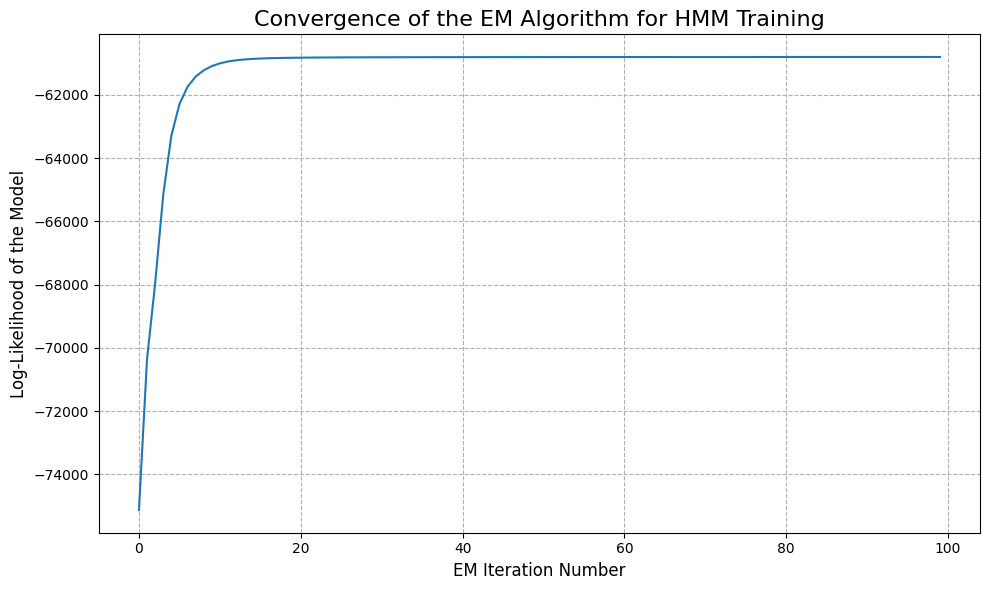

In [ ]:
log_likelihoods = model.monitor_.history

# --- Plotting the Convergence ---
plt.figure(figsize=(10, 6))

# Create the line plot
plt.plot(log_likelihoods)

# Add labels and a title for clarity
plt.title('Convergence of the EM Algorithm for HMM Training', fontsize=16)
plt.xlabel('EM Iteration Number', fontsize=12)
plt.ylabel('Log-Likelihood of the Model', fontsize=12)
plt.grid(True, ls="--")
plt.tight_layout()

plt.savefig('EM/hmm_em_convergence.png')

print("HMM convergence plot has been generated and saved as 'hmm_em_convergence.png'")

## Graphs that show how good the approximation is

Original matrix heatmap saved as 'heatmap_original.png'
Learned matrix heatmap saved as 'heatmap_learned.png'
Learned emission matrix heatmap saved as 'heatmap_emission.png'


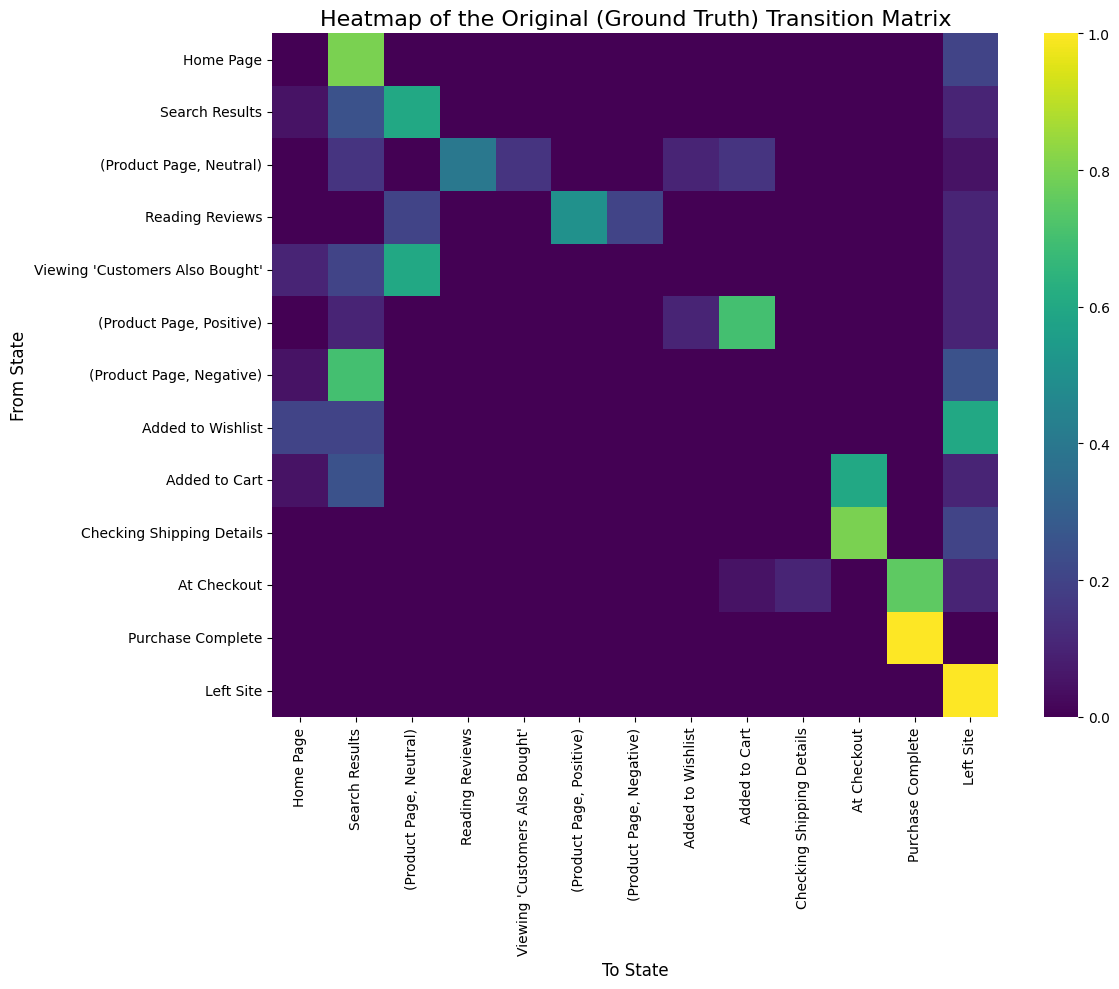

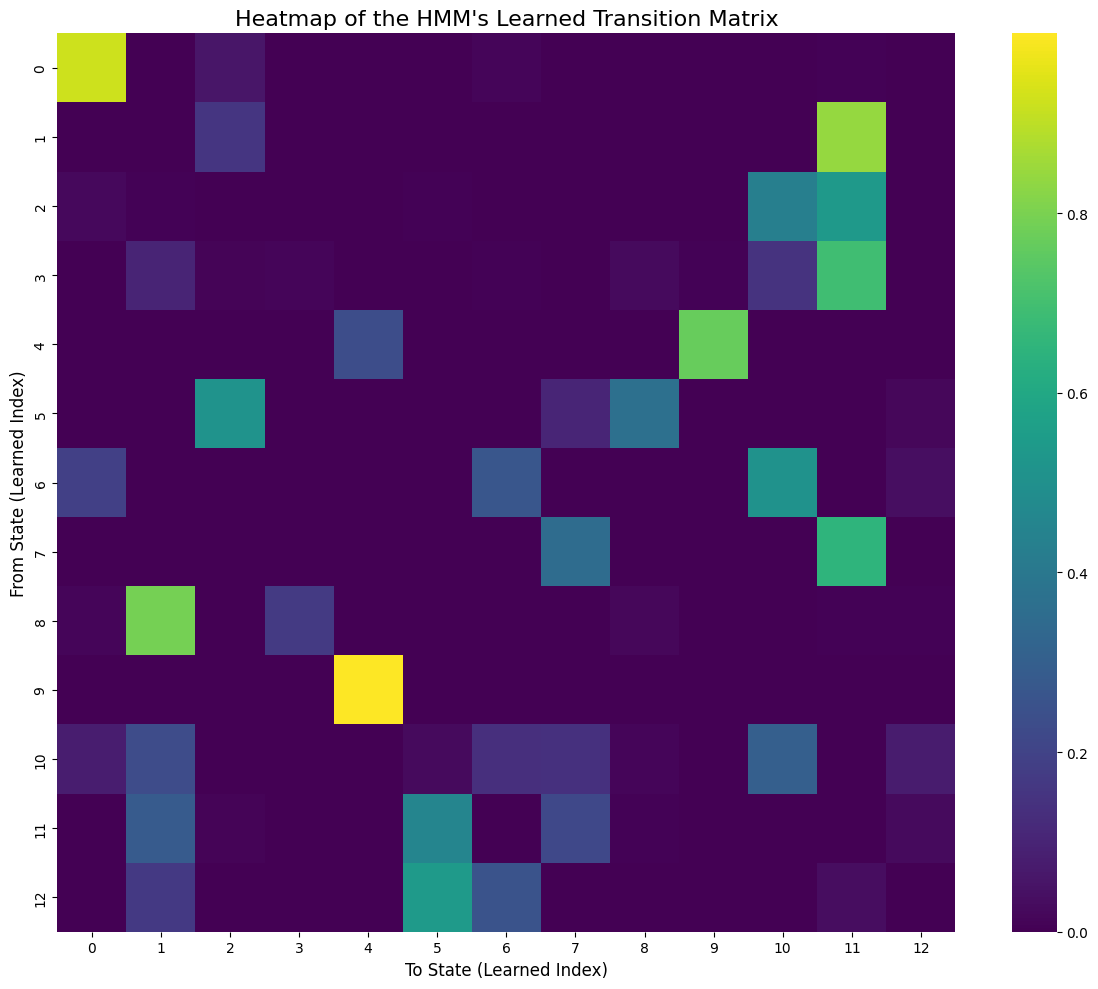

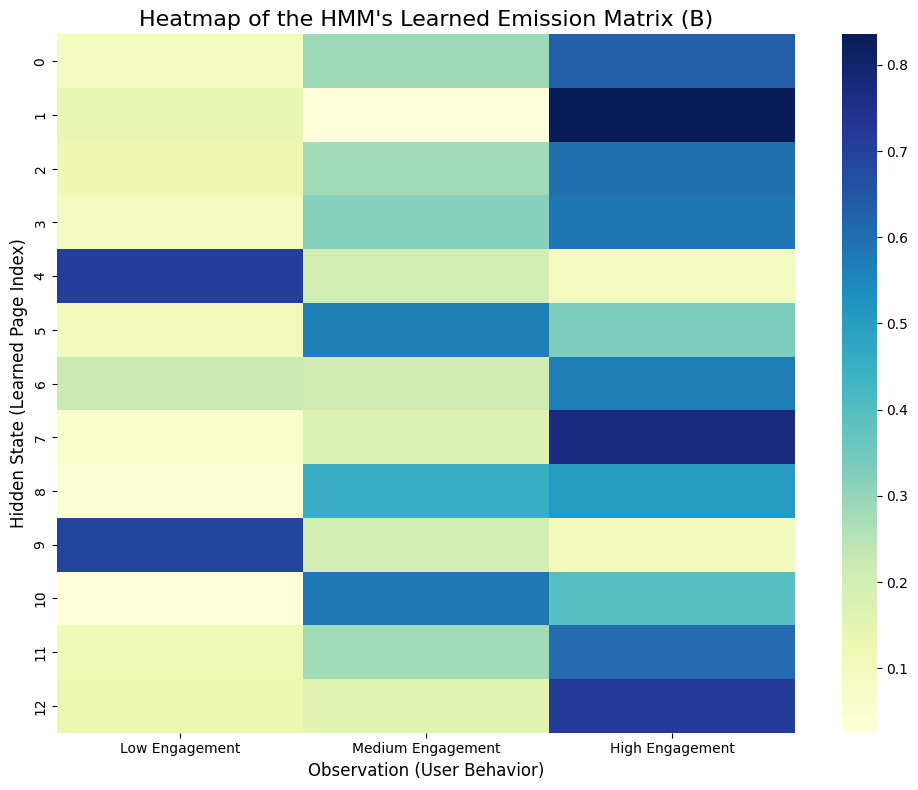

In [ ]:
original_matrix = transitions[a_dn, :, :]

# 2. Get the learned transition matrix
learned_matrix = learned_transition_matrix

# --- Create Plot 1: Heatmap of the Original Matrix ---
plt.figure(figsize=(12, 10))
sns.heatmap(original_matrix, cmap="viridis", xticklabels=states, yticklabels=states)
plt.title("Heatmap of the Original (Ground Truth) Transition Matrix", fontsize=16)
plt.xlabel("To State", fontsize=12)
plt.ylabel("From State", fontsize=12)
plt.tight_layout()
plt.savefig('EM/heatmap_original.png')
print("Original matrix heatmap saved as 'heatmap_original.png'")


# --- Create Plot 2: Heatmap of the Learned Matrix ---
plt.figure(figsize=(12, 10))
sns.heatmap(learned_matrix, cmap="viridis")
plt.title("Heatmap of the HMM's Learned Transition Matrix", fontsize=16)
plt.xlabel("To State (Learned Index)", fontsize=12)
plt.ylabel("From State (Learned Index)", fontsize=12)
plt.tight_layout()
plt.savefig('EM/heatmap_learned.png')
print("Learned matrix heatmap saved as 'heatmap_learned.png'")

# --- Create Plot 3: Heatmap of the Learned Emission Matrix ---
plt.figure(figsize=(10, 8))
sns.heatmap(learned_emission_matrix, cmap="YlGnBu", xticklabels=observations)
plt.title("Heatmap of the HMM's Learned Emission Matrix (B)", fontsize=16)
plt.xlabel("Observation (User Behavior)", fontsize=12)
plt.ylabel("Hidden State (Learned Page Index)", fontsize=12)
plt.tight_layout()
plt.savefig('EM/heatmap_emission.png')
print("Learned emission matrix heatmap saved as 'heatmap_emission.png'")

# Different EM initializations

In [ ]:
# 1. Prepare the data for hmmlearn (same as before)
observations_concatenated = np.concatenate(all_user_observations).reshape(-1, 1)
lengths = [len(obs) for obs in all_user_observations]

# 2. Set up the experiment
num_runs = 5
results = []

print(f"Starting {num_runs} HMM training runs with different initializations...")
print("-" * 30)

for i in range(num_runs):
    print(f"--- RUN {i + 1}/{num_runs} ---")
    
    model = hmm.CategoricalHMM(
        n_components=len(states),
        n_iter=100,
        tol=1e-4,
        init_params="ste",
        params="ste",
        random_state=i, # Use the loop index as the random seed
        verbose=False   # Set to False to keep the output clean
    )

    # Fit the HMM to the data
    model.fit(observations_concatenated, lengths)
    
    # Store the results from this run
    run_result = {
        "run_number": i + 1,
        "final_log_likelihood": model.score(observations_concatenated, lengths),
        "learned_transition_matrix": model.transmat_
    }
    results.append(run_result)
    
    print(f"Run {i + 1} complete. Final Log-Likelihood: {run_result['final_log_likelihood']:.2f}")

print("-" * 30)
print("All HMM training runs are complete.")
print("\n--- Summary of Final Log-Likelihoods ---")
for res in results:
    print(f"Run {res['run_number']}: {res['final_log_likelihood']:.2f}")

Starting 5 HMM training runs with different initializations...
------------------------------
--- RUN 1/5 ---
Run 1 complete. Final Log-Likelihood: -60799.07
--- RUN 2/5 ---
Run 2 complete. Final Log-Likelihood: -60801.50
--- RUN 3/5 ---
Run 3 complete. Final Log-Likelihood: -60800.43
--- RUN 4/5 ---
Run 4 complete. Final Log-Likelihood: -60798.48
--- RUN 5/5 ---
Run 5 complete. Final Log-Likelihood: -60799.51
------------------------------
All HMM training runs are complete.

--- Summary of Final Log-Likelihoods ---
Run 1: -60799.07
Run 2: -60801.50
Run 3: -60800.43
Run 4: -60798.48
Run 5: -60799.51


Generating heatmaps for each HMM run...
Saved EM/heatmap_learned_run_1.png
Saved EM/heatmap_learned_run_2.png
Saved EM/heatmap_learned_run_3.png
Saved EM/heatmap_learned_run_4.png
Saved EM/heatmap_learned_run_5.png

All heatmaps have been generated.


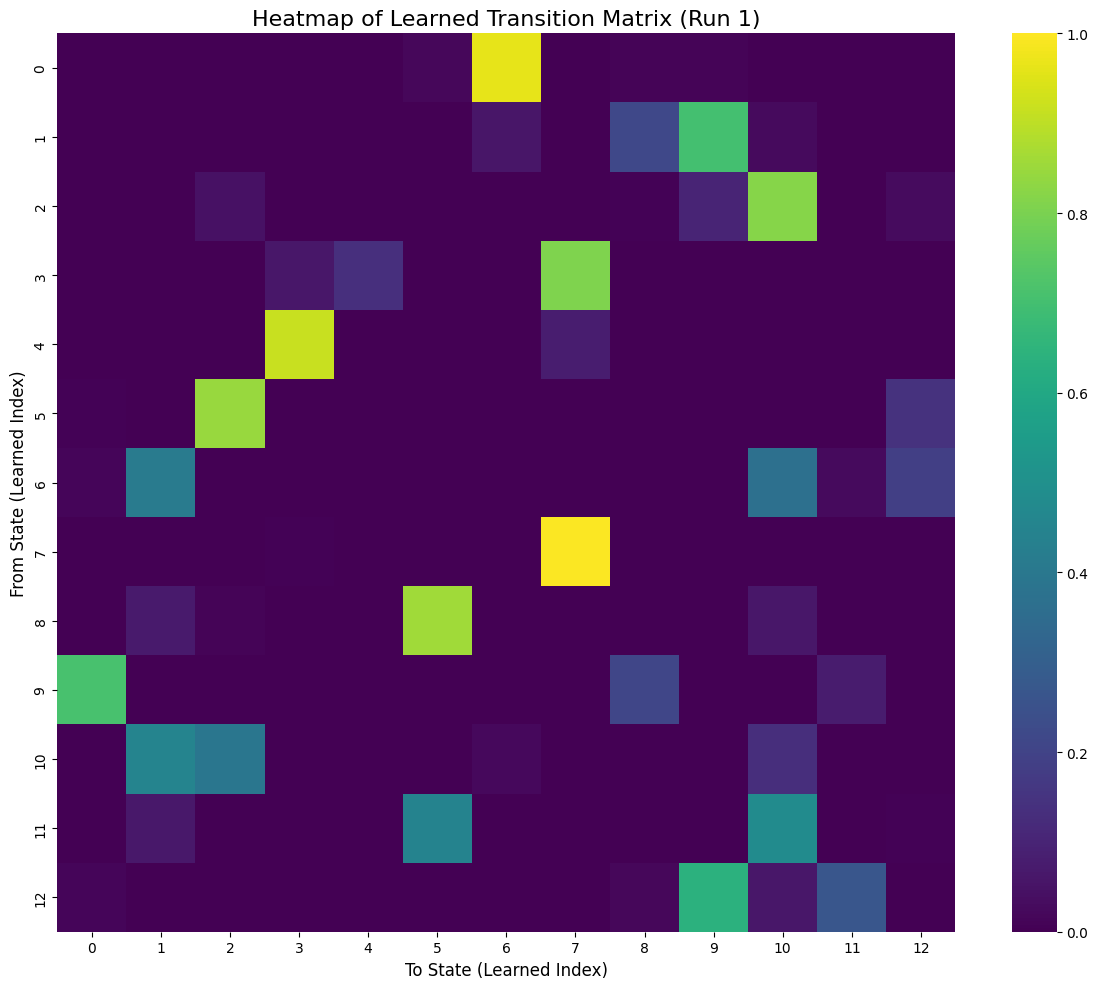

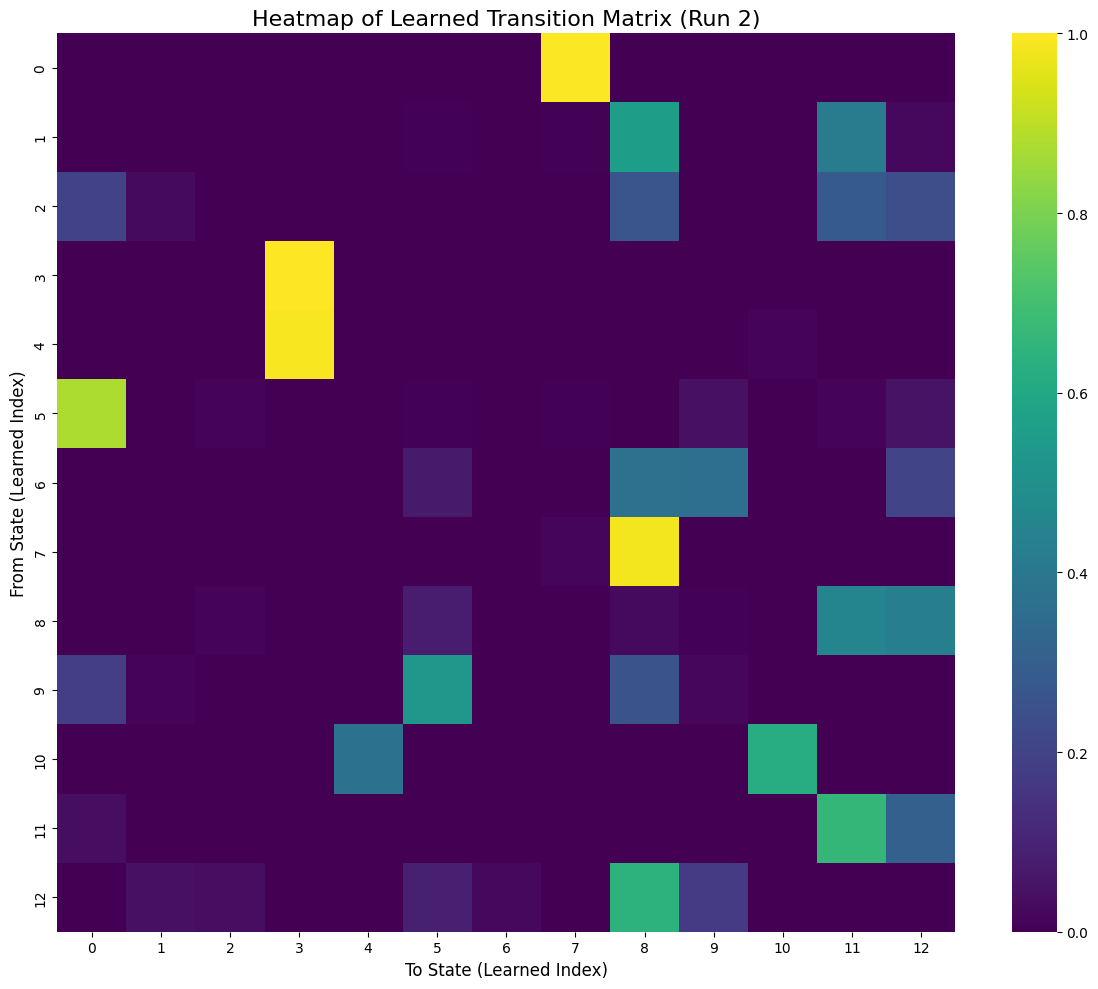

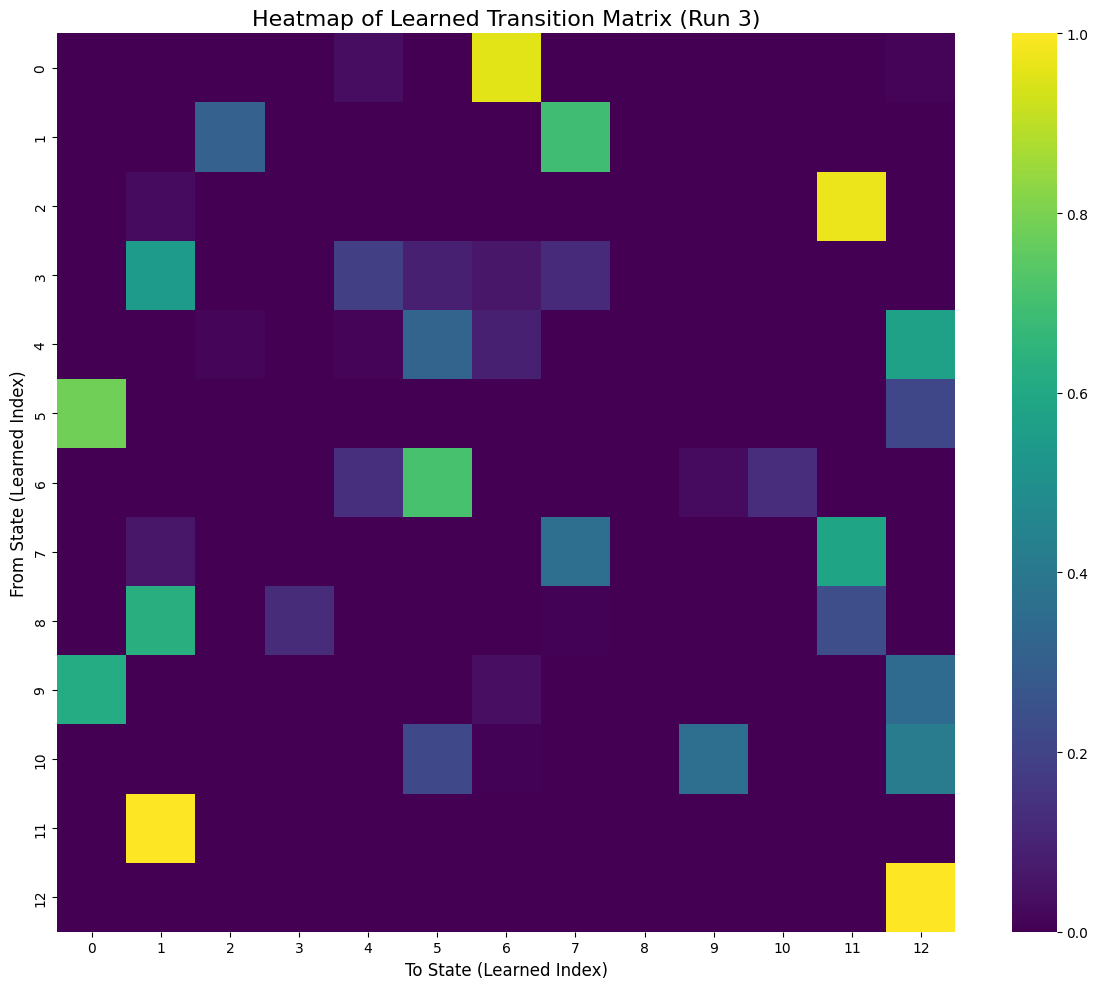

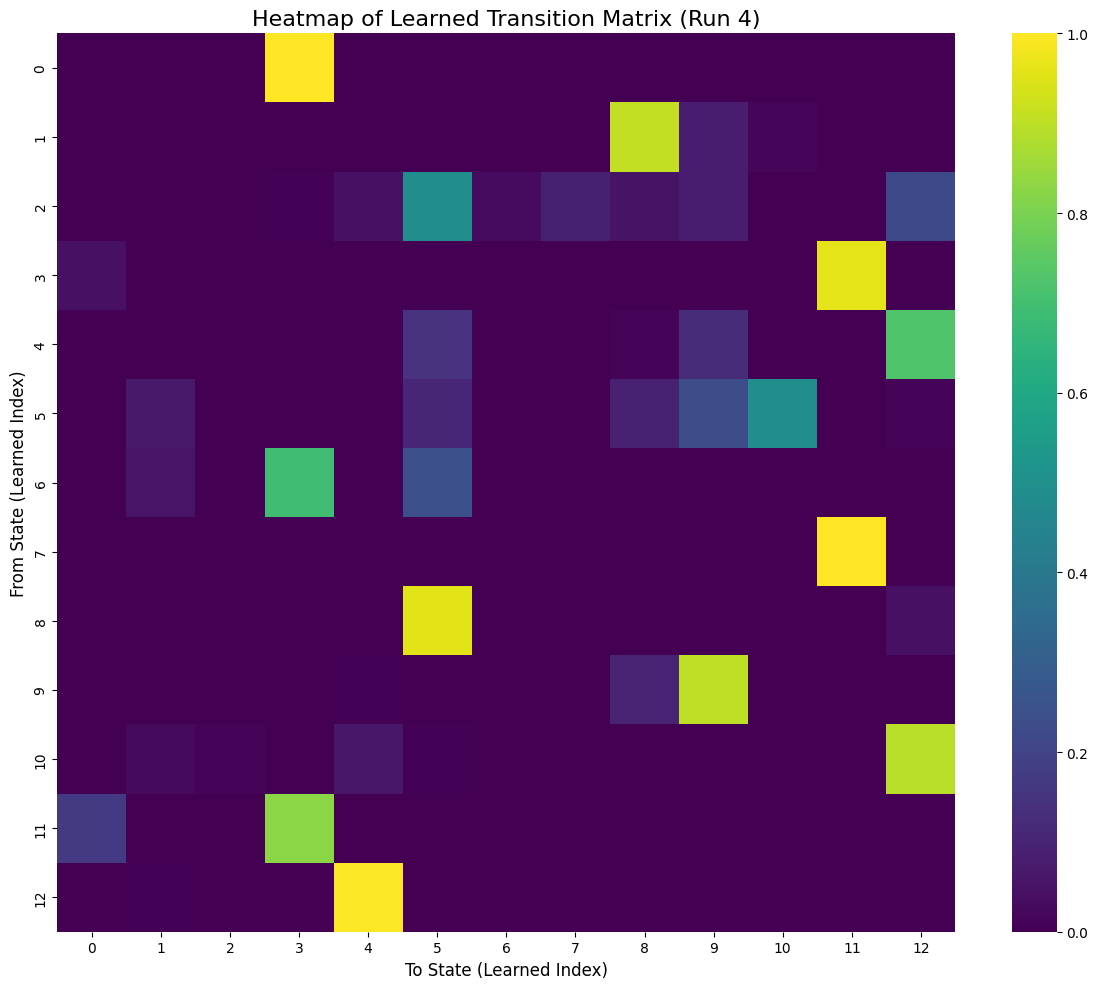

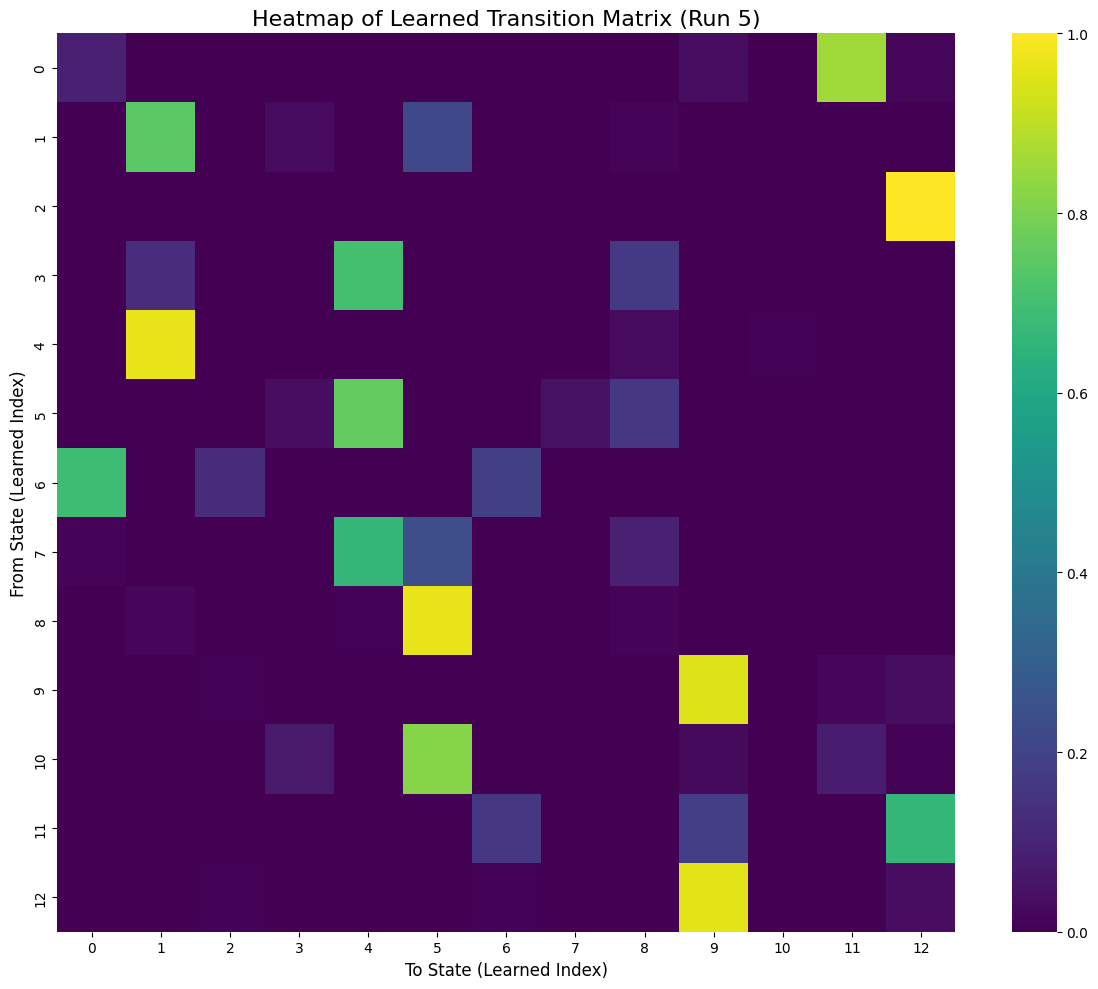

In [ ]:
print("Generating heatmaps for each HMM run...")

for res in results:
    run_num = res["run_number"]
    learned_matrix = res["learned_transition_matrix"]
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(learned_matrix, cmap="viridis", vmin=0, vmax=1) # Set vmin/vmax for consistent color scale
    
    plt.title(f"Heatmap of Learned Transition Matrix (Run {run_num})", fontsize=16)
    plt.xlabel("To State (Learned Index)", fontsize=12)
    plt.ylabel("From State (Learned Index)", fontsize=12)
    
    plt.tight_layout()
    
    filename = f'EM/heatmap_learned_run_{run_num}.png'
    plt.savefig(filename)
    print(f"Saved {filename}")

print("\nAll heatmaps have been generated.")